In [1]:
import pickle
import numpy as np
from scipy import sparse
import pandas as pd
import seaborn as sns
sns.set() ## set up style
import uuid
import time
import datetime
import matplotlib.pyplot as plt
#solved chinese display in matplotlib
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
# rcParams["font.family"] = "DFKai-SB"
rcParams['axes.unicode_minus'] = False
from tqdm import tqdm_notebook,tnrange
# from tqdm.autonotebook import tqdm
# tqdm.pandas()

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import visdom
vis=visdom.Visdom()
from BuildDataset import Tripletdataset
from Model import Encoder,Decoder,EncoderOneLayer,DecoderOneLayer
industry=['金融業', 'IC製造', 'IC設計', '電子零件元件', '電腦系統業', '石油及天然氣', '手機', '面板業', '太陽能',
       '板鋼', '被動元件', '車輛整車', '非鐵金屬', '流通業', '地產', '通訊設備', '遊戲產業', '印刷電路板相關',
       '貴金屬', '機械', '運輸事業', '電子通路', 'IC封裝測試', 'LED', '通訊服務', '消費性電子產品', '化學工業',
       '醫藥產業', '軟體業', '週邊產品', '石化業', '旅館、餐飲', '汽機車零組件', '設備儀器廠商', '條鋼', '造紙業',
       '水泥', '橡膠工業', '傳產其他', '數位相機', '顯示器', '不鏽鋼', '農林漁牧', '服務業', 'Internet相關',
       '營造工程', '休閒娛樂', '紡織中游', '生物科技', '家電', '光碟片', '建材', '成衣', '電力', '運動產業',
       '線材、盤元', '化纖原料', '其他公用事業', '大宗物資', '家居用品', '手機零組件', '食品加工', '電力設備',
       '航天軍工', '分離式元件', '電子其他', '面板零組件', '飲料相關', '電線電纜', '封測服務與材料', '礦石開採',
       '光通訊', '傳播事業', '輔助與彌補用醫材', '時尚產業', '基礎建設營運', '電聲產品', '水資源', '醫療器材通路',
       '合金鋼', '文化創意產業', '車用金屬成型', '穿戴式裝置', '其他醫療器材', '汽車內裝', '車用電子',
       '診斷與監測用醫材', '傳輸介面', '電子化工材料', '電池材料相關', '資產股', '醫療管理服務', '體外診斷用醫材', '煤',
       '射頻前端晶片', '控股公司', '無店舖販售', '手術與治療用醫材', '金屬礦採選', '生物辨識相關']

In [2]:
## Load industry dictionary
with open("D:4.AutoencoderForArticle.Mid-Industry/dict_guid_sparsebow_20000_single.v05.p","rb") as f:
    dict_guid_sparsebow_single= pickle.load(f)
with open("D:4.AutoencoderForArticle.Mid-Industry/dict_singleindustry_guid.p","rb") as f:
    dict_singleindustry_guid= pickle.load(f)

In [3]:
## Industry with news more than 100 pics
industry_partial=industry[:80]

In [4]:
len(industry_partial)

80

#### Configuration for split dataset to triain and test

In [5]:
Split=8/18
Split_train_test=8/10

#### Sample part of Dataset

In [6]:
dict_split_industry_guid={ ind:np.random.choice(dict_singleindustry_guid[ind],
                                                     size=int(Split*len(dict_singleindustry_guid[ind])),
                                                     replace=False) for ind in industry_partial}

In [7]:
dict_train_industry_guid={ind:dict_split_industry_guid[ind][:int(Split_train_test*len(dict_split_industry_guid[ind]))]
                          for ind in dict_split_industry_guid}
dict_test_industry_guid={ind:dict_split_industry_guid[ind][int(Split_train_test*len(dict_split_industry_guid[ind])):]
                          for ind in dict_split_industry_guid}
with open("dict_train_industry_guid.p","wb") as f:
    pickle.dump(dict_train_industry_guid,f)
with open("dict_test_industry_guid.p","wb") as f:
    pickle.dump(dict_test_industry_guid,f)

In [8]:
dict_str_list=dict_split_industry_guid
analysis={i:len(dict_str_list[i]) for i in dict_str_list }
analysis=pd.Series(analysis)
analysis.sort_values(ascending=False)

金融業         7083
IC製造        3338
IC設計        3187
電子零件元件      2932
電腦系統業       2282
石油及天然氣      2160
手機          2139
面板業         1929
太陽能         1819
板鋼          1656
被動元件        1643
車輛整車        1631
非鐵金屬        1612
流通業         1540
地產          1392
通訊設備        1368
遊戲產業        1341
印刷電路板相關     1299
貴金屬         1174
機械          1078
運輸事業        1077
電子通路        1008
IC封裝測試       905
LED          798
通訊服務         797
消費性電子產品      707
化學工業         698
醫藥產業         671
軟體業          669
週邊產品         669
            ... 
光碟片          228
建材           197
成衣           195
電力           187
運動產業         182
線材、盤元        181
化纖原料         176
其他公用事業       168
大宗物資         165
家居用品         158
手機零組件        139
食品加工         129
電力設備         123
航天軍工         117
分離式元件        115
電子其他         108
面板零組件        102
飲料相關          93
電線電纜          91
封測服務與材料       90
礦石開採          78
光通訊           63
傳播事業          61
時尚產業          60
輔助與彌補用醫材      60
基礎建設營運        54
電聲產品          52
水資源           

In [9]:
dict_str_list=dict_train_industry_guid
analysis={i:len(dict_str_list[i]) for i in dict_str_list }
analysis=pd.Series(analysis)
analysis.sort_values(ascending=False)

金融業         4958
IC製造        2336
IC設計        2230
電子零件元件      2052
電腦系統業       1597
石油及天然氣      1512
手機          1497
面板業         1350
太陽能         1273
板鋼          1159
被動元件        1150
車輛整車        1141
非鐵金屬        1128
流通業         1078
地產           974
通訊設備         957
遊戲產業         938
印刷電路板相關      909
貴金屬          821
機械           754
運輸事業         753
電子通路         705
IC封裝測試       633
LED          558
通訊服務         557
消費性電子產品      494
化學工業         488
醫藥產業         469
軟體業          468
週邊產品         468
            ... 
光碟片          159
建材           137
成衣           136
電力           130
運動產業         127
線材、盤元        126
化纖原料         123
其他公用事業       117
大宗物資         115
家居用品         110
手機零組件         97
食品加工          90
電力設備          86
航天軍工          81
分離式元件         80
電子其他          75
面板零組件         71
飲料相關          65
電線電纜          63
封測服務與材料       62
礦石開採          54
光通訊           44
傳播事業          42
時尚產業          42
輔助與彌補用醫材      42
基礎建設營運        37
電聲產品          36
水資源           

In [10]:
dict_str_list=dict_test_industry_guid
analysis={i:len(dict_str_list[i]) for i in dict_str_list }
analysis=pd.Series(analysis)
analysis.sort_values(ascending=False)

金融業         2125
IC製造        1002
IC設計         957
電子零件元件       880
電腦系統業        685
石油及天然氣       648
手機           642
面板業          579
太陽能          546
板鋼           497
被動元件         493
車輛整車         490
非鐵金屬         484
流通業          462
地產           418
通訊設備         411
遊戲產業         403
印刷電路板相關      390
貴金屬          353
機械           324
運輸事業         324
電子通路         303
IC封裝測試       272
通訊服務         240
LED          240
消費性電子產品      213
化學工業         210
醫藥產業         202
軟體業          201
週邊產品         201
            ... 
光碟片           69
建材            60
成衣            59
電力            57
線材、盤元         55
運動產業          55
化纖原料          53
其他公用事業        51
大宗物資          50
家居用品          48
手機零組件         42
食品加工          39
電力設備          37
航天軍工          36
分離式元件         35
電子其他          33
面板零組件         31
封測服務與材料       28
電線電纜          28
飲料相關          28
礦石開採          24
光通訊           19
傳播事業          19
時尚產業          18
輔助與彌補用醫材      18
基礎建設營運        17
電聲產品          16
水資源           

#### Configure to train

In [21]:
Epochs=5
P=3
K=6
PK=P*K
inputDim=20000
repzDim=100
alpha=2
PK*(K-1)*(PK-K)

1080

#### Dataset  & Model & Criterion & Optimizer Instantiation

In [22]:
dataset=Tripletdataset(industry_partial,
                       dict_train_industry_guid,
                       dict_guid_sparsebow_single,
                       P=P,K=K,
                      )
testset=Tripletdataset(industry_partial,
                       dict_test_industry_guid,
                       dict_guid_sparsebow_single,
                       P=P,K=K,
                      )

modelEncoder = EncoderOneLayer(inputDim,repzDim).to(device)
modelEncoder.eval()
modelDecoder = DecoderOneLayer(repzDim,inputDim).to(device)
modelEncoder.eval()

def criterionTri(h0,h1,h2,reduction="mean"):
    h01=(h0*h1).sum(dim=1)
    h02=(h0*h2).sum(dim=1)
    Lt=torch.log(1+torch.exp(h02-h01))
    if reduction=="mean":
        return Lt.mean()
    if reduction=="none": assert False,"this function not yet" 
        
##待 驗 證
def criterionTriModfy(h0,h1,h2,reduction="mean"):
    h01=(h0*h1).sum(dim=1)
    h02=(h0*h2).sum(dim=1)
    Lt=torch.log(1+torch.exp(-h01))-torch.log( 1 - torch.sigmoid(h02))
    if reduction=="mean":
        return Lt.mean()

criterionRC=torch.nn.BCELoss(reduction="mean") ## There is one called BCEWithLogitsLoss 
# optimizerSgd=torch.optim.SGD([{"params":modelEncoder.parameters()},
#                            {"params":modelDecoder.parameters()},
#                            ],
#                           lr=0.001,
#                             )
optimizer=torch.optim.Adam([{"params":modelEncoder.parameters()},
                           {"params":modelDecoder.parameters()},
                           ])

In [ ]:
modelEncoder

In [ ]:
modelDecoder

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([-0.2504, -0.1770, -0.8129, -0.5878], grad_fn=<NegBackward>)

In [10]:
def opts(**kwords):
    opts={"markers":False,"xlabel":"epochs","title":"Total Loss","width":1200,"heigh":300,"xtickmax":100}
    for k in kwords:
        opts[k]=kwords[k]
    return opts

2019-01-17 09:29:54.325581


#### Train

In [13]:
trainingloss={"loss":[],"lossRA":[],"lossRP":[],"lossRN":[],"lossT":[]}
testloss={"loss":[],"lossRA":[],"lossRP":[],"lossRN":[],"lossT":[]}
s_start=datetime.datetime.now()
s_total=time.time()
print(s_start)
for ep in tnrange(Epochs):
    s_epoch=time.time()
    s_epochWithAllstep=time.time()
    ep+=1
    dataset.shuffle()
    for i, (batchData,batchTest) in enumerate(zip(dataset,testset)):
        
        s_batch=time.time()
        
        optimizer.zero_grad()
        
        s_prepare=time.time()
        ## Train 
        ## array int8 to float 32
        batchAnchor=batchData["batch_anchor"].astype(np.float32) 
        batchPositive=batchData["batch_positive"].astype(np.float32)
        batchNegative=batchData["batch_negative"].astype(np.float32)
        ## array  to tensor float 32
        batchAnchorTensor=torch.tensor(batchAnchor,dtype=torch.float32,device=device)
        batchPositiveTensor=torch.tensor(batchPositive,dtype=torch.float32,device=device)
        batchNegativeTensor=torch.tensor(batchNegative,dtype=torch.float32,device=device)
        
        e_prepare=time.time()
        
        s_inference=time.time()
        ## Inference
        #### encoding
        anchorRepz   = modelEncoder(batchAnchorTensor)
        positiceRepz = modelEncoder(batchPositiveTensor)
        negativeRepz = modelEncoder(batchNegativeTensor)
        #### decoding
        anchorRc   = modelDecoder(anchorRepz)
        positiveRc = modelDecoder(positiceRepz)
        negativeRc = modelDecoder(negativeRepz)
        
        lossRA = criterionRC(anchorRc,batchAnchorTensor)
        lossRP = criterionRC(positiveRc,batchPositiveTensor)
        lossRN = criterionRC(negativeRc,batchNegativeTensor)
        
        lossT = criterionTri(anchorRepz,positiceRepz,negativeRepz,reduction="mean")
        
        loss = lossRA + lossRP + lossRN + alpha*lossT
        
        e_inference = time.time()
        
        
        ## backward
        s_backward = time.time()
        loss.backward()
        e_backward = time.time()
        
        s_step=time.time()
        ## update
        optimizer.step()
        e_step=time.time()
        
        e_batch=time.time()
        ## record
#         with torch.no_grad():
#             trainingloss["loss"].append(loss.item())
#             trainingloss["lossRA"].append(lossRA.item())
#             trainingloss["lossRP"].append(lossRP.item())
#             trainingloss["lossRN"].append(lossRN.item())
#             trainingloss["lossT"].append(lossT.item())
    e_epoch=time.time()
    print("-------------------------------")
    print("epoch :",ep,"/",Epochs)
    print("epoch :",ep,"/",Epochs)
    print("loss  :",loss.item())
    print("lossRA:",lossRA.item(),",","lossRP:",lossRP.item(),",","lossRN:",lossRN.item())
    print("lossT :",lossT.item())
    print("Batch-Time:",np.round(e_batch-s_batch,3),"s")
    print("Batch-PreTime",np.round(e_prepare-s_prepare,3),"s")
    print("Batch-InfTime:",np.round(e_inference-s_inference,3),"s")
    print("Batch-BackTime:",np.round(e_backward-s_backward,3),"s")
    print("Batch-UpdateTime:",np.round(e_step-s_step,3),"s")
    print("Epoch-Time",np.round(e_epoch-s_epoch,3),"s")
    
    s_trainRecord=time.time()
    ## Trainset record
    with torch.no_grad():
        trainingloss["loss"].append(loss.item())
        trainingloss["lossRA"].append(lossRA.item())
        trainingloss["lossRP"].append(lossRP.item())
        trainingloss["lossRN"].append(lossRN.item())
        trainingloss["lossT"].append(lossT.item())
    e_trainRecord=time.time()
    s_testInference=time.time()
    ## Test Inference every epoch
    with torch.no_grad():
        ## array int8 to float 32
        batchAnchor   = batchTest["batch_anchor"].astype(np.float32) 
        batchPositive = batchTest["batch_positive"].astype(np.float32)
        batchNegative = batchTest["batch_negative"].astype(np.float32)
        ## array  to tensor float 32
        batchAnchorTensor   = torch.tensor(batchAnchor,dtype=torch.float32,device=device)
        batchPositiveTensor = torch.tensor(batchPositive,dtype=torch.float32,device=device)
        batchNegativeTensor = torch.tensor(batchNegative,dtype=torch.float32,device=device)
        ## Inference
        #### encoding
        anchorRepz   = modelEncoder(batchAnchorTensor)
        positiceRepz = modelEncoder(batchPositiveTensor)
        negativeRepz = modelEncoder(batchNegativeTensor)
        #### decoding
        anchorRc   = modelDecoder(anchorRepz)
        positiveRc = modelDecoder(positiceRepz)
        negativeRc = modelDecoder(negativeRepz)
        #### loss
        lossRA_test = criterionRC(anchorRc,batchAnchorTensor)
        lossRP_test = criterionRC(positiveRc,batchPositiveTensor)
        lossRN_test = criterionRC(negativeRc,batchNegativeTensor)
        lossT_test  = criterionTri(anchorRepz,positiceRepz,negativeRepz,reduction="mean")
        loss_test   = lossRA_test+lossRP_test+lossRN_test+alpha*lossT_test
    e_testInference=time.time()    
    s_testRecord=time.time()
    ### Testset Record
    testloss["loss"].append(loss_test.item())
    testloss["lossRA"].append(lossRA_test.item())
    testloss["lossRP"].append(lossRP_test.item())
    testloss["lossRN"].append(lossRN_test.item())
    testloss["lossT"].append(lossT_test.item())
    e_testRecord=time.time()
    s_plot=time.time()
    ##plot 
    win="train loss "
    vis.line(Y=[loss.item()]  ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossT"
    vis.line(Y=[lossT.item()] ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossRA"
    vis.line(Y=[lossRA.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossRP"
    vis.line(Y=[lossRP.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossRN"
    vis.line(Y=[lossRN.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="test loss "
    vis.line(Y=[loss_test.item()]  ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossT"
    vis.line(Y=[lossT_test.item()] ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossRA"
    vis.line(Y=[lossRA_test.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossRP"
    vis.line(Y=[lossRP_test.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossRN"
    vis.line(Y=[lossRN_test.item()],X=[ep],win=win,update="append",opts=opts(title=win))  
    e_plot=time.time()
    e_epochWithAllstep=time.time()

    print("Trainset record:",np.round(e_trainRecord-s_trainRecord,3),"s")
    print("Test Inference",np.round(e_testInference-s_testInference,3),"s")
    print("Testset Record:",np.round(e_testRecord-s_testRecord,3),"s")
    print("Visom Plot:",np.round(s_plot-s_plot,3),"s")    
    print("EpochWithAllstep",np.round(e_trainRecord-s_epochWithAllstep,3),"s")
e_total=time.time()
e_end=datetime.datetime.now()
print("START:",s_start)
print("END:",e_end)
print("Time:",np.round(e_total-s_total,3),"s")

-------------------------------
epoch : 1 / 5
epoch : 1 / 5
loss  : 1.248692512512207
lossRA: 0.11516084522008896 , lossRP: 0.11515992134809494 , lossRN: 0.11515942960977554
lossT : 0.4516061544418335
Batch-Time: 0.193 s
Batch-PreTime 0.013 s
Batch-InfTime: 0.065 s
Batch-BackTime: 0.085 s
Batch-UpdateTime: 0.03 s
Epoch-Time 5.157 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2 / 5
epoch : 2 / 5
loss  : 1.0322901010513306
lossRA: 0.06786343455314636 , lossRP: 0.06786274909973145 , lossRN: 0.0678630992770195
lossT : 0.4143504202365875
Batch-Time: 0.198 s
Batch-PreTime 0.012 s
Batch-InfTime: 0.066 s
Batch-BackTime: 0.088 s
Batch-UpdateTime: 0.032 s
Epoch-Time 5.229 s
Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3 / 5
epoch : 3 / 5
loss  : 2.208651542663574
lossRA: 0.06649576872587204 , lossRP: 0.06649474054574966 , lossRN: 0.066

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002120A92D6D8>],
      dtype=object)

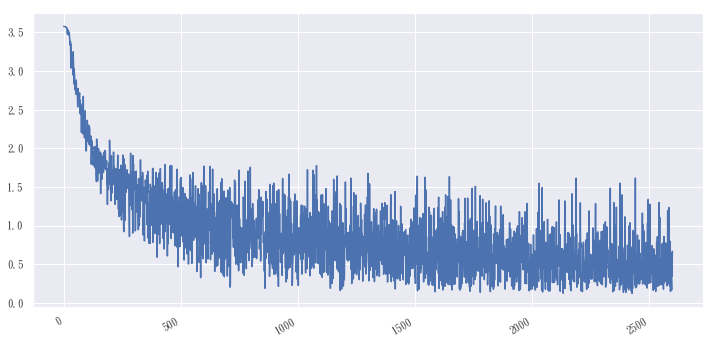

In [49]:
df=pd.DataFrame({"train_loss":trainingloss["loss"],"test_loss":testloss["loss"]})
df[["train_loss","test_loss"]].plot(figsize=(12,6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002120A8F7240>],
      dtype=object)

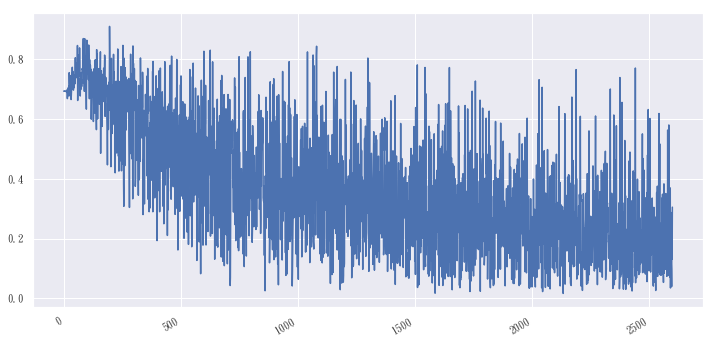

In [48]:
df=pd.DataFrame({"train_lossT":trainingloss["lossT"],"test_lossT":testloss["lossT"]})
df[["train_lossT","test_lossT"]].plot(figsize=(12,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002120A7A3438>,
      dtype=object)

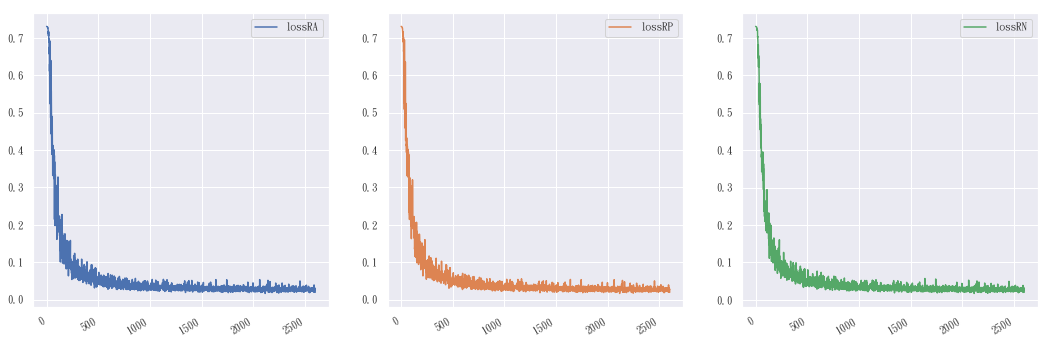

In [44]:
# df=pd.DataFrame(trainingloss)
df=pd.DataFrame({"train_lossRA":trainingloss["lossRA"],"test_lossRA":testloss["lossRA"],
                "train_lossRP":trainingloss["lossRP"],"test_lossRP":testloss["lossRP"],
                 "train_lossRN":trainingloss["lossRN"],"test_lossRN":testloss["lossRN"],
                })
# df[["train_lossT","test_lossT"]].plot(figsize=(12,6))
df[["train_lossRA","train_lossRN","train_lossRN","test_lossRA","test_lossRP","test_lossRN"]].plot(subplots=True,
                                                                                                   figsize=(18,6),layout=(2,3))

## Save model

In [ ]:
modelstatpath="EncoderStat.pt"
torch.save(modelEncoder.state_dict(),modelstatpath) 

## Save DATA

In [ ]:
dfTrain=pd.DataFrame(trainingloss)
dfTest=pd.DataFrame(testloss)

In [ ]:
trainLossPath="TrainLoss.p"
testLossPath="TestLoss.p"
dfTrain.to_pickle(trainLossPath)
dfTest.to_pickle(testLossPath)

### PLOT

In [147]:
y=torch.randn(2)
win=vis.line(Y=[1,2],X=[1,4],win=win,update="append",opts=opts(win="Total-loss-2"))

In [144]:
win="test"
# opts={"markers":True,"xlabel":"epochs","title":"test Loss","width":1200,"heigh":300}
y=torch.randn(3)
win=vis.line(y,X=[1,2,3],win=win,opts=opts(),name="train-loss")

In [145]:
win="X"
# opts={"markers":True,"xlabel":"epochs","title":"X Loss","width":1200,"heigh":300}
y=torch.randn(3)
win=vis.line(y,X=[1,2,3],win=win,opts=opts(),name="train-loss")

In [146]:
vis